In [29]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import random
import numpy as np
import os

In [30]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=transform)
test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               download=False,
                               transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                               

In [44]:
def gen_sec(x: torch.Tensor, n: int) -> list:
    # x now is a tensor
    secrets = []
    batch_sz = x.shape[0]
    x_d = x.shape[1]
    len_sec = x_d // n
    for i in range(n):
        sec = torch.zeros_like(x)
        sec[:, len_sec * i: len_sec * (i + 1)] = x[:, len_sec * i: len_sec * (i + 1)]
        secrets.append(sec)
    # print(f"x_d is {x_d}")
    return secrets

x = np.arange(32)
x = torch.Tensor(np.tile(x, (4, 1)))
# print(x)
secrets = gen_sec(x, 8)

print(secrets)

[tensor([[0., 1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]), tensor([[0., 0., 0., 0., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 4., 5., 6., 7., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0

In [45]:
def collect_sec(secrets: list, k: int, valid=True) -> torch.Tensor:
    n = len(secrets)
    if valid:
        selected_idx = random.sample(range(n), k)
    else:
        selected_idx = random.sample(range(n), k - 1)  # any k - 1 secrets would not work
    collected = torch.zeros_like(secrets[0])
    for idx in selected_idx:
        collected += secrets[idx]
    return collected

print(collect_sec(secrets, 6, True))
print("=====================================")
print(collect_sec(secrets, 6, False))
    

tensor([[ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
          0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
          0.,  0.,  0.,  0.]])
tensor([[ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 10., 11., 12., 13.,
         14., 15.,  0.,  0.,  0.,  0., 20., 21., 22., 23.,  0.,  0.,  0.,  0.,
         28., 29., 30., 31.],
        [ 0.,  1.,  2.,  3.,  0.,  0.,  0.,  0.,  8.,  9., 

In [81]:
class Autoencoder(nn.Module):
    def __init__(self, n, k):
        super(Autoencoder, self).__init__()
        self.n = n
        self.k = k
        self.encoder = nn.Sequential(
            nn.Linear(784, 32),
            # nn.ReLU(),
            # nn.Linear(256, 32),
            # nn.ReLU(),
            # nn.Linear(n, k),
            # nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            # nn.Linear(32, 256),
            # nn.ReLU(),
            nn.Linear(32, 784),
            nn.Sigmoid(),
        )

    # def forward(self, x):
    #     x = self.encoder(x)  
    #     x = self.decoder(x)
    #     return x
    
    def forward(self, x):
        x = self.encoder(x)  
        secrets = gen_sec(x, self.n)  # a pool with n secrets
        
        valid_x = collect_sec(secrets, self.k, True)
        invalid_x = collect_sec(secrets, self.k, False)
        valid_y = self.decoder(valid_x)
        invalid_y = self.decoder(invalid_x)
        return valid_y, invalid_y

In [82]:
def train(n, k, epochs=50, alpha=0.5):
    model = Autoencoder(n, k).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    losses = []
    for epoch in range(epochs):
        for img, _ in train_loader:
            img = img.view(img.size(0), -1).to(device)
            invalid_img = torch.zeros_like(img)
            # print(img.shape)
            output, invalid_output = model(img)
            loss = alpha * criterion(output, img) + (1 - alpha) * criterion(invalid_output, invalid_img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        losses.append(loss.item())
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    return losses, model
        

In [85]:
n_k = [(8, 6), (8, 7), (16, 15), (32, 31)]
losses_list = []

for n, k in n_k:
    print(f"===BEGIN TRAINING n: {n}, k: {k}===")
    losses, model = train(n, k, 20)
    model_path = f"model_n_{n}_k_{k}.pth"
    torch.save(model.state_dict(), model_path)
    losses_list.append(losses)
# print(losses_list)
with open("losses.txt", "w") as f:
    for losses in losses_list:
        f.write(str(losses))
        f.write("\n")


===BEGIN TRAINING n: 8, k: 6===
Epoch [1/20], Loss: 0.4647
Epoch [2/20], Loss: 0.4621
Epoch [3/20], Loss: 0.4629
Epoch [4/20], Loss: 0.4609
Epoch [5/20], Loss: 0.4597
Epoch [6/20], Loss: 0.4603
Epoch [7/20], Loss: 0.4590
Epoch [8/20], Loss: 0.4533
Epoch [9/20], Loss: 0.4563
Epoch [10/20], Loss: 0.4522
Epoch [11/20], Loss: 0.4530
Epoch [12/20], Loss: 0.4556
Epoch [13/20], Loss: 0.4544
Epoch [14/20], Loss: 0.4534
Epoch [15/20], Loss: 0.4479
Epoch [16/20], Loss: 0.4524
Epoch [17/20], Loss: 0.4533
Epoch [18/20], Loss: 0.4483
Epoch [19/20], Loss: 0.4519
Epoch [20/20], Loss: 0.4550
===BEGIN TRAINING n: 8, k: 7===
Epoch [1/20], Loss: 0.4629
Epoch [2/20], Loss: 0.4621
Epoch [3/20], Loss: 0.4625
Epoch [4/20], Loss: 0.4603
Epoch [5/20], Loss: 0.4615
Epoch [6/20], Loss: 0.4546
Epoch [7/20], Loss: 0.4498
Epoch [8/20], Loss: 0.4540
Epoch [9/20], Loss: 0.4534
Epoch [10/20], Loss: 0.4467
Epoch [11/20], Loss: 0.4530
Epoch [12/20], Loss: 0.4499
Epoch [13/20], Loss: 0.4475
Epoch [14/20], Loss: 0.4490
Ep

In [11]:
def plot_losses(losses_list):
    for i, losses in enumerate(losses_list):
        plt.plot(losses, label=f"n: {n_k[i][0]}, k: {n_k[i][1]}")
    plt.legend()
    plt.title("Losses Curve with respect to different n and k")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

# plot_losses(losses_list)

In [86]:
def plot_samples(model):
    fig = plt.figure()
    plt.figure(figsize=(15, 10))

    num_samples = 5
    for i in range(num_samples):
        idx = random.randint(0, len(test_dataset) - 1)
        img = test_dataset[idx][0][0]
        
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Origin: {i}")

        plt.subplot(3, num_samples, i + 6)
        with torch.no_grad():
            reconstructed, invalid_recons = model(img.view(-1, 784).to(device))
        plt.imshow(reconstructed.view(28, 28).to('cpu'))
        plt.title(f"Valid: {i}")

        plt.subplot(3, num_samples, i + 11)
        plt.imshow(invalid_recons.view(28, 28).to('cpu'))
        plt.title(f"Invalid: {i}")


model path: model_n_32_k_31.pth


<Figure size 432x288 with 0 Axes>

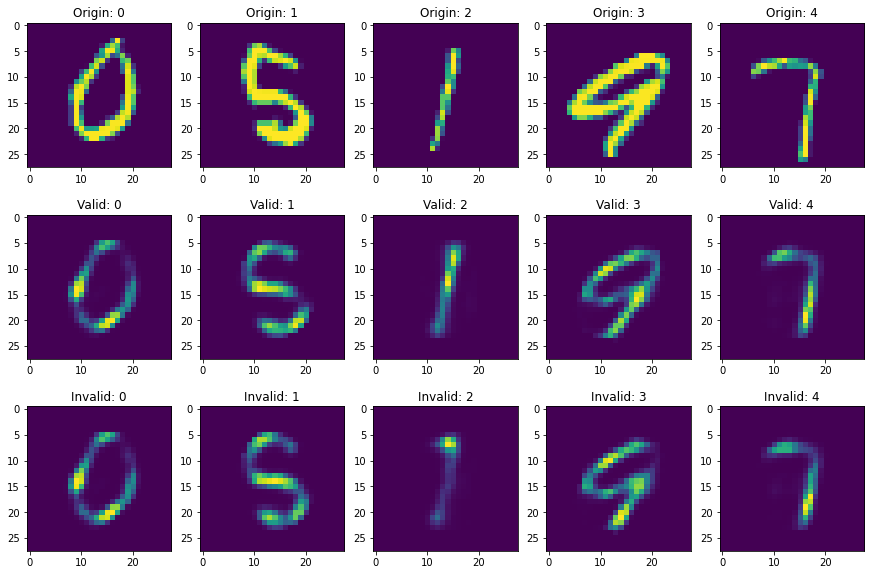

<Figure size 432x288 with 0 Axes>

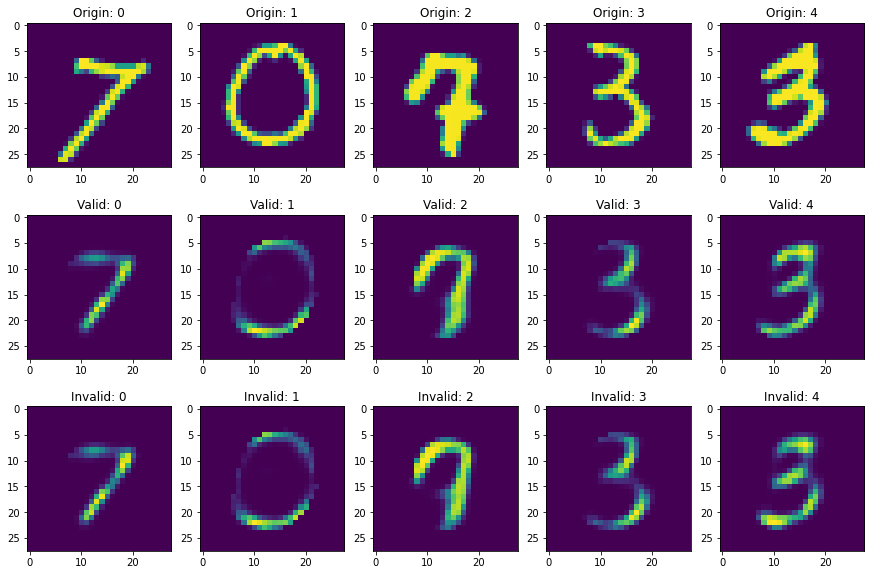

<Figure size 432x288 with 0 Axes>

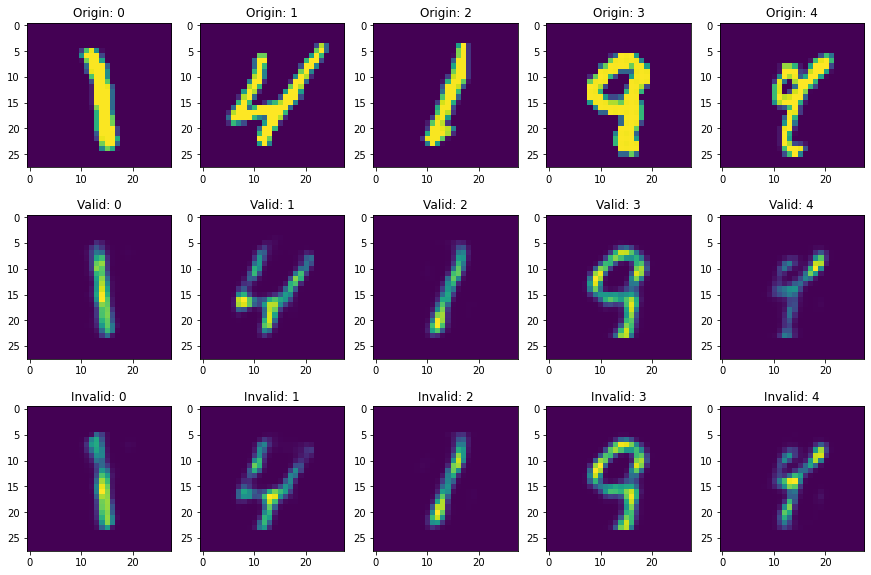

<Figure size 432x288 with 0 Axes>

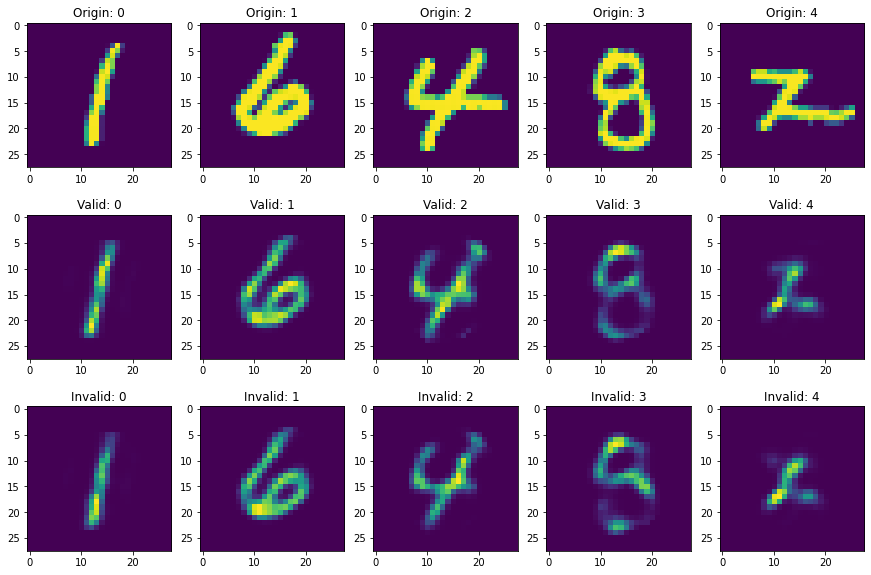

In [89]:
print(f"model path: {model_path}")
for model_pth in os.listdir("./models"):
    model = Autoencoder(n, k).to(device)
    model.load_state_dict(torch.load(model_pth))
    plot_samples(model)

In [91]:
# model_32_30 = Autoencoder(32, 30).to(device)
_, model_32_30 = train(32, 30, 50, alpha=0.4)

Epoch [1/50], Loss: 0.3700
Epoch [2/50], Loss: 0.3692
Epoch [3/50], Loss: 0.3710
Epoch [4/50], Loss: 0.3716
Epoch [5/50], Loss: 0.3693
Epoch [6/50], Loss: 0.3654
Epoch [7/50], Loss: 0.3680
Epoch [8/50], Loss: 0.3629
Epoch [9/50], Loss: 0.3655
Epoch [10/50], Loss: 0.3622
Epoch [11/50], Loss: 0.3632
Epoch [12/50], Loss: 0.3628
Epoch [13/50], Loss: 0.3632
Epoch [14/50], Loss: 0.3651
Epoch [15/50], Loss: 0.3644
Epoch [16/50], Loss: 0.3638
Epoch [17/50], Loss: 0.3621
Epoch [18/50], Loss: 0.3611
Epoch [19/50], Loss: 0.3602
Epoch [20/50], Loss: 0.3586
Epoch [21/50], Loss: 0.3619
Epoch [22/50], Loss: 0.3614
Epoch [23/50], Loss: 0.3612
Epoch [24/50], Loss: 0.3597
Epoch [25/50], Loss: 0.3634
Epoch [26/50], Loss: 0.3639
Epoch [27/50], Loss: 0.3619
Epoch [28/50], Loss: 0.3630
Epoch [29/50], Loss: 0.3667
Epoch [30/50], Loss: 0.3642
Epoch [31/50], Loss: 0.3601
Epoch [32/50], Loss: 0.3614
Epoch [33/50], Loss: 0.3671
Epoch [34/50], Loss: 0.3600
Epoch [35/50], Loss: 0.3630
Epoch [36/50], Loss: 0.3637
E

In [92]:
_, model_16_15 = train(16, 15, 50, alpha=0.4)

Epoch [1/50], Loss: 0.3713
Epoch [2/50], Loss: 0.3708
Epoch [3/50], Loss: 0.3689
Epoch [4/50], Loss: 0.3695
Epoch [5/50], Loss: 0.3709
Epoch [6/50], Loss: 0.3682
Epoch [7/50], Loss: 0.3697
Epoch [8/50], Loss: 0.3669
Epoch [9/50], Loss: 0.3651
Epoch [10/50], Loss: 0.3629
Epoch [11/50], Loss: 0.3646
Epoch [12/50], Loss: 0.3642
Epoch [13/50], Loss: 0.3597
Epoch [14/50], Loss: 0.3635
Epoch [15/50], Loss: 0.3630
Epoch [16/50], Loss: 0.3643
Epoch [17/50], Loss: 0.3608
Epoch [18/50], Loss: 0.3608
Epoch [19/50], Loss: 0.3596
Epoch [20/50], Loss: 0.3672
Epoch [21/50], Loss: 0.3629
Epoch [22/50], Loss: 0.3612
Epoch [23/50], Loss: 0.3631
Epoch [24/50], Loss: 0.3650
Epoch [25/50], Loss: 0.3636
Epoch [26/50], Loss: 0.3620
Epoch [27/50], Loss: 0.3622
Epoch [28/50], Loss: 0.3633
Epoch [29/50], Loss: 0.3595
Epoch [30/50], Loss: 0.3631
Epoch [31/50], Loss: 0.3623
Epoch [32/50], Loss: 0.3636
Epoch [33/50], Loss: 0.3638
Epoch [34/50], Loss: 0.3594
Epoch [35/50], Loss: 0.3578
Epoch [36/50], Loss: 0.3591
E

In [93]:
_, model_8_7_04 = train(8, 7, 50, alpha=0.4)
_, model_8_7_03 = train(8, 7, 50, alpha=0.3)

Epoch [1/50], Loss: 0.3689
Epoch [2/50], Loss: 0.3714
Epoch [3/50], Loss: 0.3689
Epoch [4/50], Loss: 0.3702
Epoch [5/50], Loss: 0.3690
Epoch [6/50], Loss: 0.3684
Epoch [7/50], Loss: 0.3688
Epoch [8/50], Loss: 0.3662
Epoch [9/50], Loss: 0.3666
Epoch [10/50], Loss: 0.3594
Epoch [11/50], Loss: 0.3658
Epoch [12/50], Loss: 0.3610
Epoch [13/50], Loss: 0.3613
Epoch [14/50], Loss: 0.3624
Epoch [15/50], Loss: 0.3630
Epoch [16/50], Loss: 0.3644
Epoch [17/50], Loss: 0.3616
Epoch [18/50], Loss: 0.3623
Epoch [19/50], Loss: 0.3576
Epoch [20/50], Loss: 0.3622
Epoch [21/50], Loss: 0.3601
Epoch [22/50], Loss: 0.3582
Epoch [23/50], Loss: 0.3614
Epoch [24/50], Loss: 0.3631
Epoch [25/50], Loss: 0.3646
Epoch [26/50], Loss: 0.3621
Epoch [27/50], Loss: 0.3578
Epoch [28/50], Loss: 0.3596
Epoch [29/50], Loss: 0.3584
Epoch [30/50], Loss: 0.3582
Epoch [31/50], Loss: 0.3643
Epoch [32/50], Loss: 0.3648
Epoch [33/50], Loss: 0.3645
Epoch [34/50], Loss: 0.3571
Epoch [35/50], Loss: 0.3631
Epoch [36/50], Loss: 0.3574
E

<Figure size 432x288 with 0 Axes>

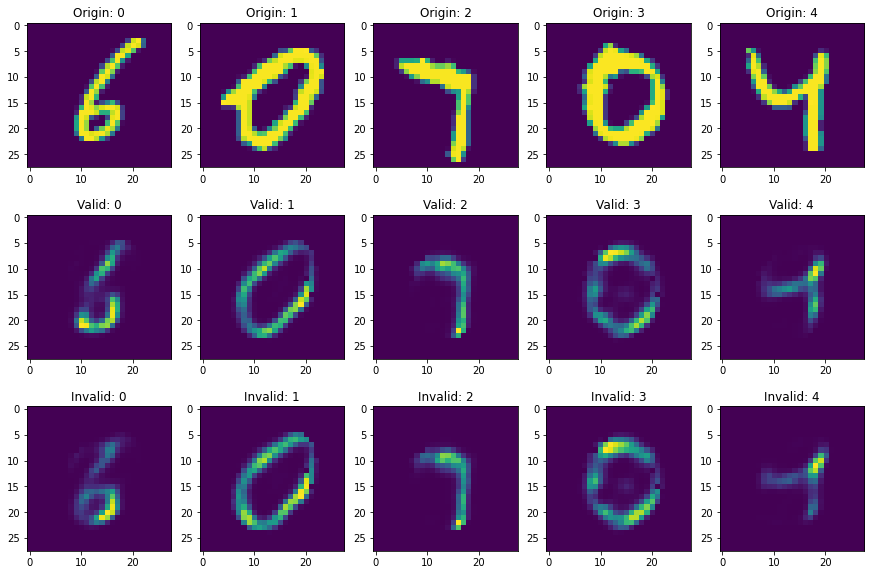

In [90]:
plot_samples(model_32_30)


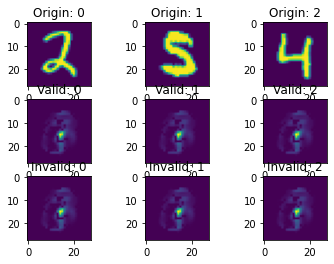

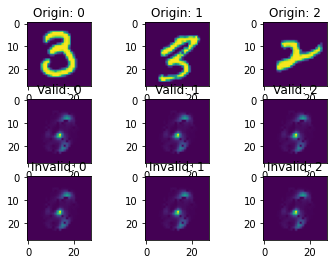

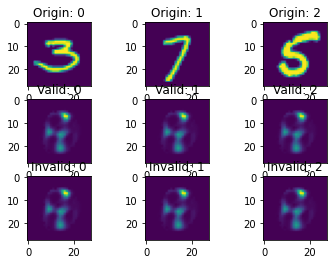

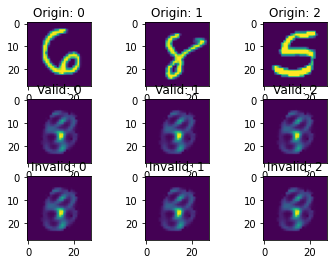

In [33]:
for curr_path, dirs, files in os.walk("./models"):
    for file in files:
        model_path = os.path.join(curr_path, file)
        model.load_state_dict(torch.load(model_path))
        plot_samples(model)
        

In [136]:
def plot_different_models(models):
    # generate a random image
    idx = random.randint(0, len(test_dataset) - 1)
    img = test_dataset[idx][0][0]

    fig, axs = plt.subplots(3, 4, figsize=(12, 9))
    fig.title("Comparation of Different Models' Reconstruction")
    original = img
    
    for i in range(4):
        n, k = n_k[i]
        model = models[i]
        with torch.no_grad():
            valid, invalid = model(img.view(-1, 784).to(device))
            
        # Original image
        axs[0, i].imshow(original.numpy().squeeze())
        axs[0, i].set_title(f'Model {n}_{k} Original')
        axs[0, i].axis('off')

        # Valid image
        axs[1, i].imshow(valid.view(28, 28).to(device))
        axs[1, i].set_title(f'Model {n}_{k} Valid')
        axs[1, i].axis('off')

        # Invalid image
        axs[2, i].imshow(invalid.view(28, 28).to(device))
        axs[2, i].set_title(f'Model {n}_{k} Invalid')
        axs[2, i].axis('off')

    fig.suptitle('Overall Figure Title')
    plt.tight_layout()
    plt.show()

        

In [140]:
models = [model_32_30, model_16_15, model_8_7_04, model_8_7_03]
# for model in models:
# model_path = os.path.join("./models", model)
torch.save(model_32_30.state_dict, "./models/model_32_31.pth")
torch.save(model_16_15.state_dict, "./models/model_16_15.pth")
torch.save(model_8_7_04.state_dict, "./models/model_8_7_04.pth")
torch.save(model_8_7_03.state_dict, "./models/model_8_7_03.pth")


# model_32_30
# plot_different_models(models)

<Figure size 432x288 with 0 Axes>

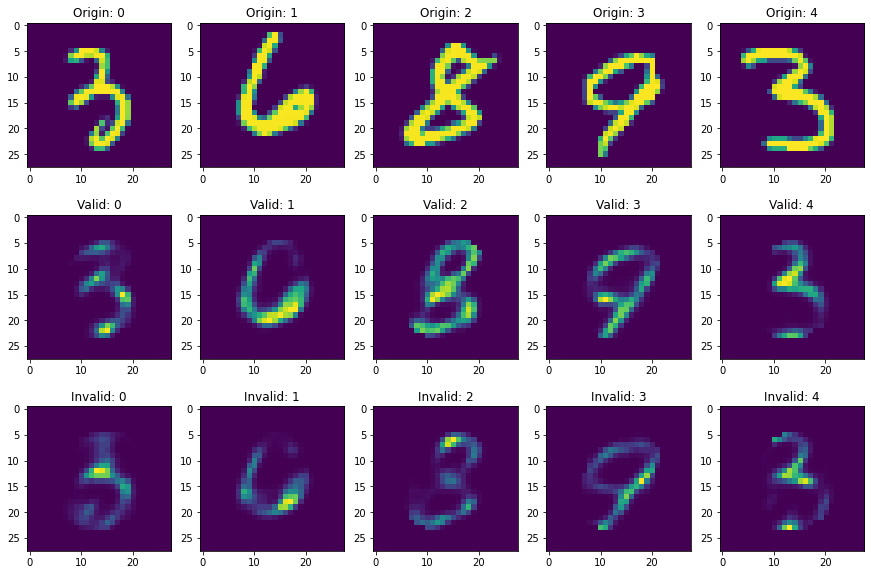

In [145]:
plot_samples(model_8_7_03)